# Modleing and prediction using Machine lerining and Deep learining

##### An end-to-end Data Science project with a regression adapted for time series as solution was created four machine learning models to forecast the sales. 

In [1]:
import math
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import inflection
import datetime
import warnings
import random
import pickle
import json

import xgboost               as xgb
    
from tabulate                import tabulate
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso


from IPython.core.display    import HTML
from IPython.display         import Image
# Versão da Linguagem Python
from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
warnings.filterwarnings( 'ignore' )

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


### Function used as supporter 

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    def cramer_v( x, y ):
        cm = pd.crosstab( x, y ).values # Confusion Matrix
        n = cm.sum()
        r, k = cm.shape

        chi2 = ss.chi2_contingency( cm )[0]
        chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

        kcorr = k - (k-1)**2/(n-1)
        rcorr = r - (r-1)**2/(n-1)

        return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def ml_error ( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])
# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)  
        end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7) 

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) } )

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### loading of dataset from local repo.

In [4]:
df_train_data = pd.read_csv(r"C:\Users\Genet Shanko\Pharmaceutical_Sales_Prediction\DVC_Dataset\train.csv")
df_store_data = pd.read_csv(r"C:\Users\Genet Shanko\Pharmaceutical_Sales_Prediction\DVC_Dataset\Store.csv")

# Merge


In [5]:
df_train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df_train_store = pd.merge( df_train_data, df_store_data,how='left', on = 'Store' )

In [8]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## DATA DESCRIPTION

In [9]:
#Copy dataset
df1 =df_train_store.copy()

### Rename Columns

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

#Rename Columns

df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [12]:
##### Data Dimension and Data type

In [13]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


In [14]:
#  transform datatype of the variable data to datetime
df1['date'] = pd.to_datetime( df1[ 'date' ] )
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### missing values

In [15]:
# checking NA values sum
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df


,missing values count,percentage
store,0,0.00
day_of_week,0,0.00
date,0,0.00
sales,0,0.00
customers,0,0.00
open,0,0.00
promo,0,0.00
state_holiday,0,0.00
school_holiday,0,0.00
store_type,0,0.00


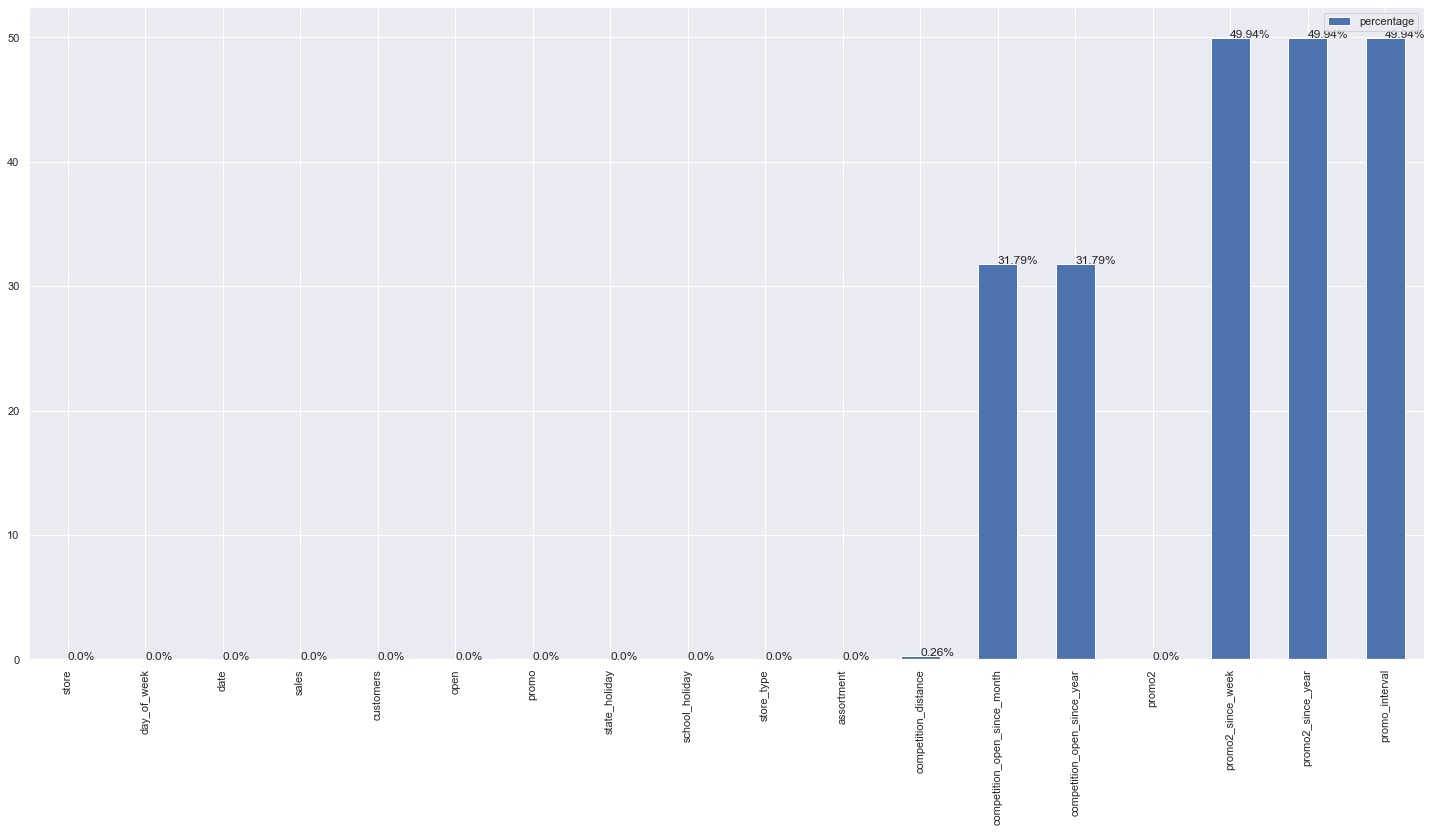

In [16]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

### Filling the missing values

In [17]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'],
                                               axis = 1 )
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'],
                                               axis = 1 )
# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'],
                                               axis = 1 )
# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'],
                                               axis = 1 )
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map( month_map )
#df1['is_promo'] = df1[[ 'promo_interval', 'month_map' ]].apply(lambda x: 0 if x['promo_interval'] == 0 else x['month_map'] in x['promo_interval'])

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
dtype: object

### Change Types

In [20]:
f1 = df1.astype({'competition_open_since_month':'int64', 'competition_open_since_year':'int64', 'promo2_since_week':'int64', 'promo2_since_year':'int64' })

In [21]:
df1.dtypes # checking datatypes transformation

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
dtype: object

### Descriptive Statistics

In [22]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [23]:
# separate numerical and categorical attributes

num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

### Numerical Attributes

In [24]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attributes

In [25]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

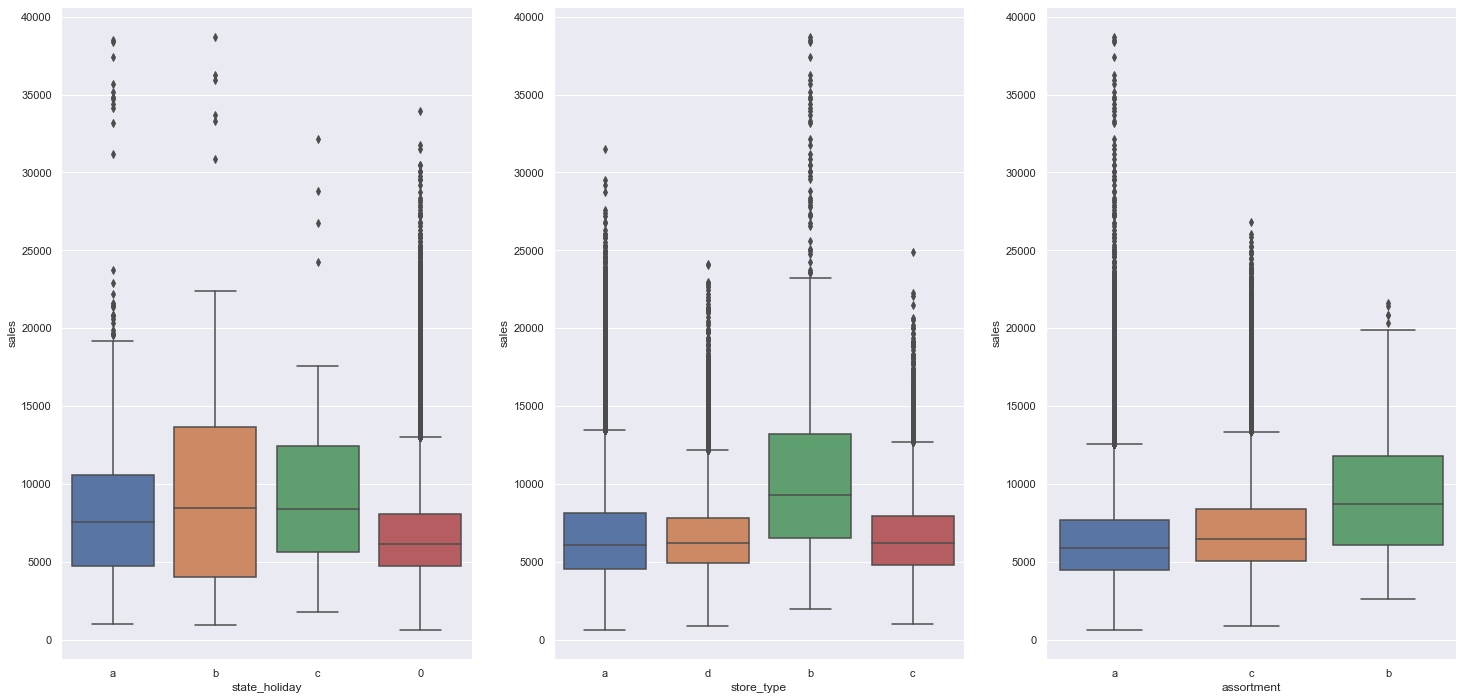

In [26]:
# plot boxplots of categorical features against target variable
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot(x='state_holiday', y= 'sales', data=aux1);

plt.subplot (1, 3, 2)
sns.boxplot(x='store_type', y= 'sales', data=aux1);

plt.subplot (1, 3, 3)
sns.boxplot(x='assortment', y= 'sales', data=aux1);

### Feature Engineering

In [29]:
df2 = df1.copy()

In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [35]:
df3 = df2.copy()

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales']> 0)]

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [38]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week
0,1,5,2015-07-31,5263,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,2015,7,31,31,2015-30
1,2,5,2015-07-31,6064,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,2015,7,31,31,2015-30
2,3,5,2015-07-31,8314,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,2015,7,31,31,2015-30
3,4,5,2015-07-31,13995,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,2015,7,31,31,2015-30
4,5,5,2015-07-31,4822,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,2015,7,31,31,2015-30


### EXPLORATORY DATA ANALYSIS (EDA)

In [39]:
df4 = df3.copy()

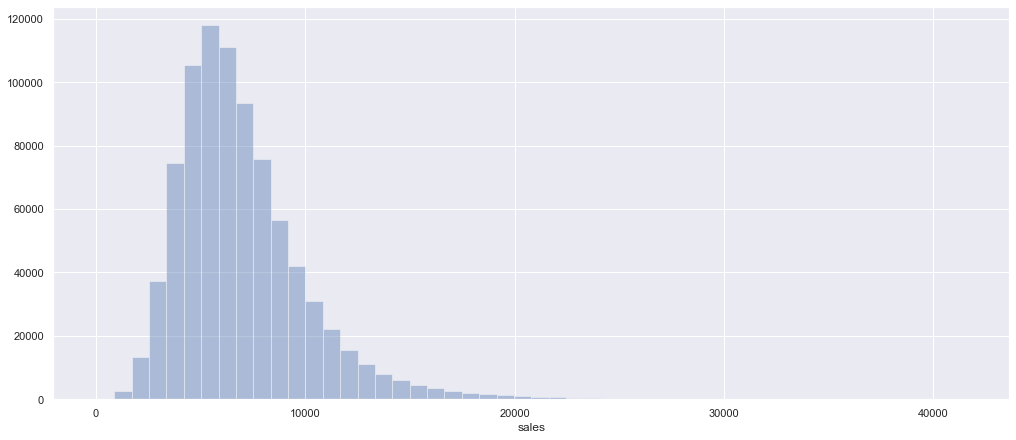

In [40]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['sales'], kde = False);


#### Numerical Variable

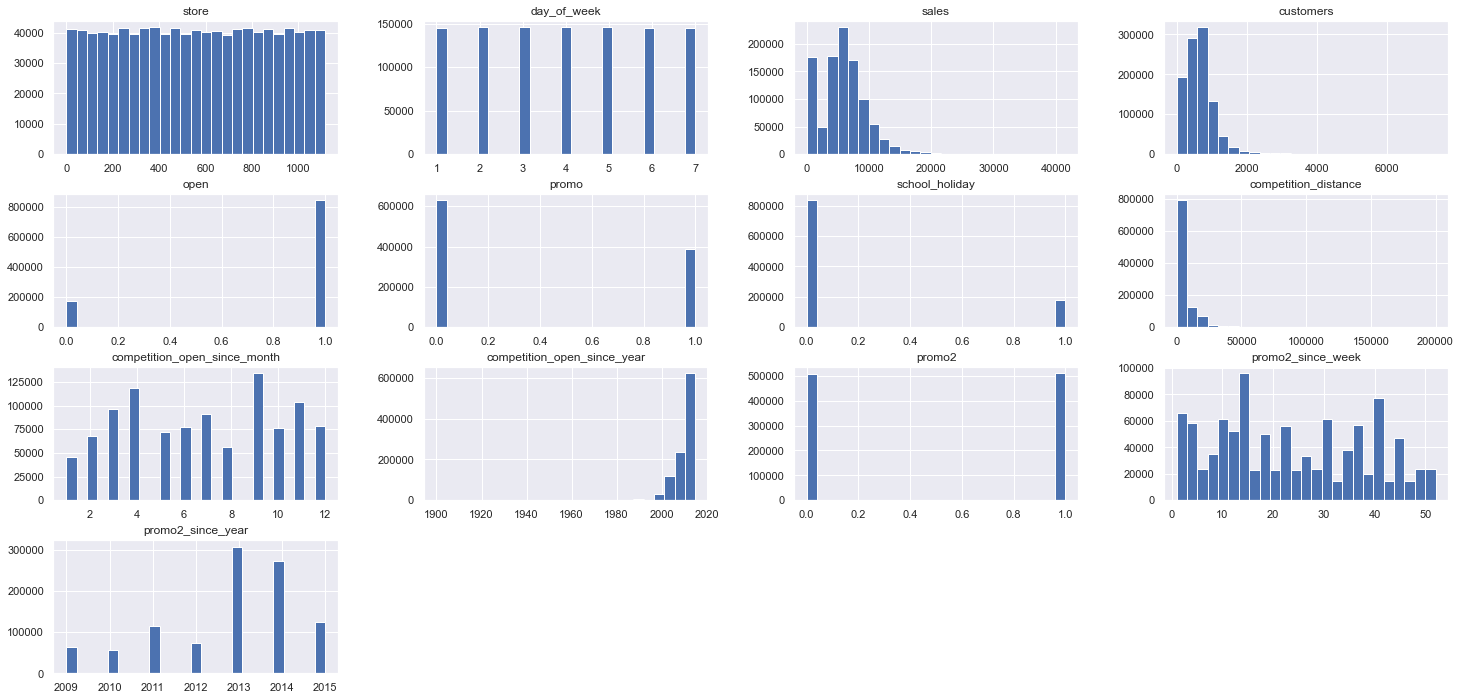

In [41]:
num_attributes.hist(bins = 25);

### Categorical Variable

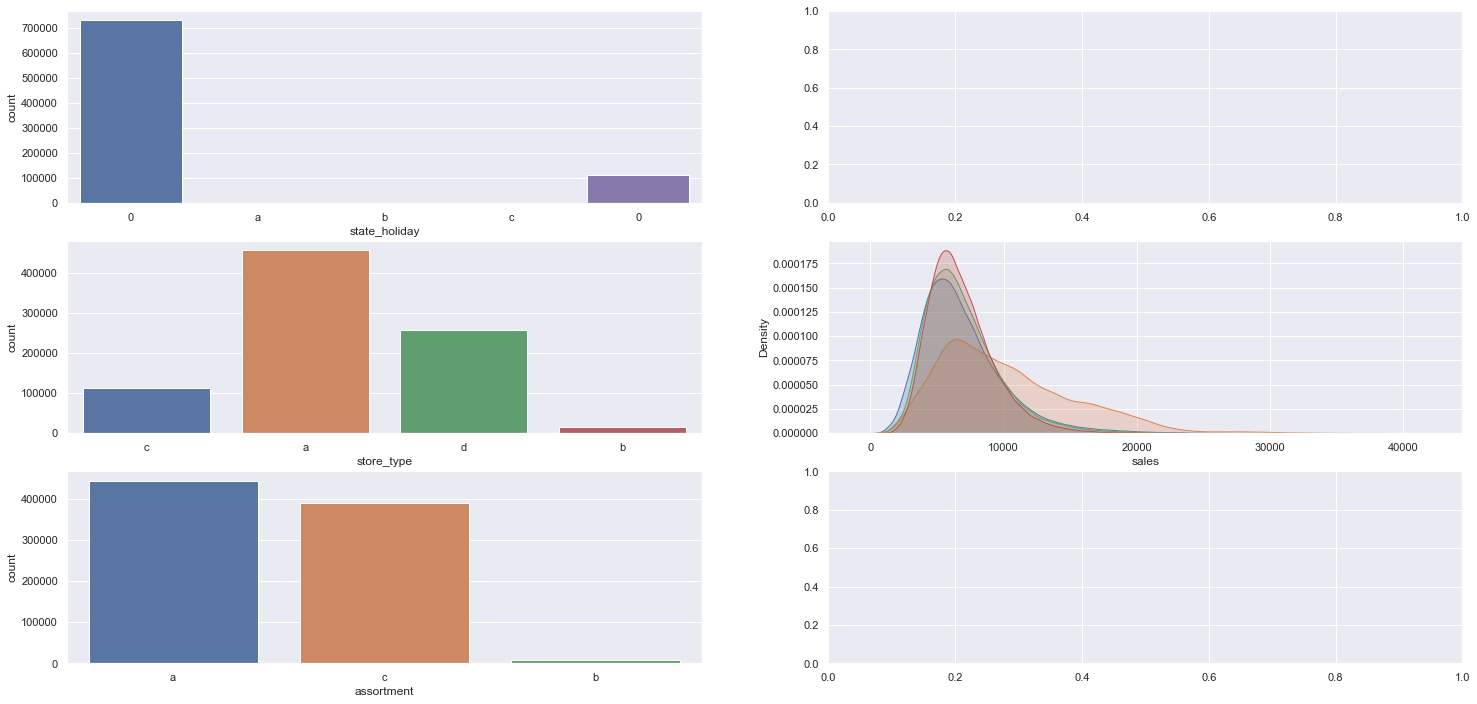

In [42]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True )
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data = df4, x = df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot(data = df4, x = df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'a']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'b']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'c']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['store_type'] == 'd']['sales'], shade = True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(data = df4, x = df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'basic']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extended']['sales'], shade = True)
sns.kdeplot(data = df4, x = df4[df4['assortment'] == 'extra']['sales'], shade = True);

### Bivariate Analysis

<AxesSubplot:xlabel='year_week'>

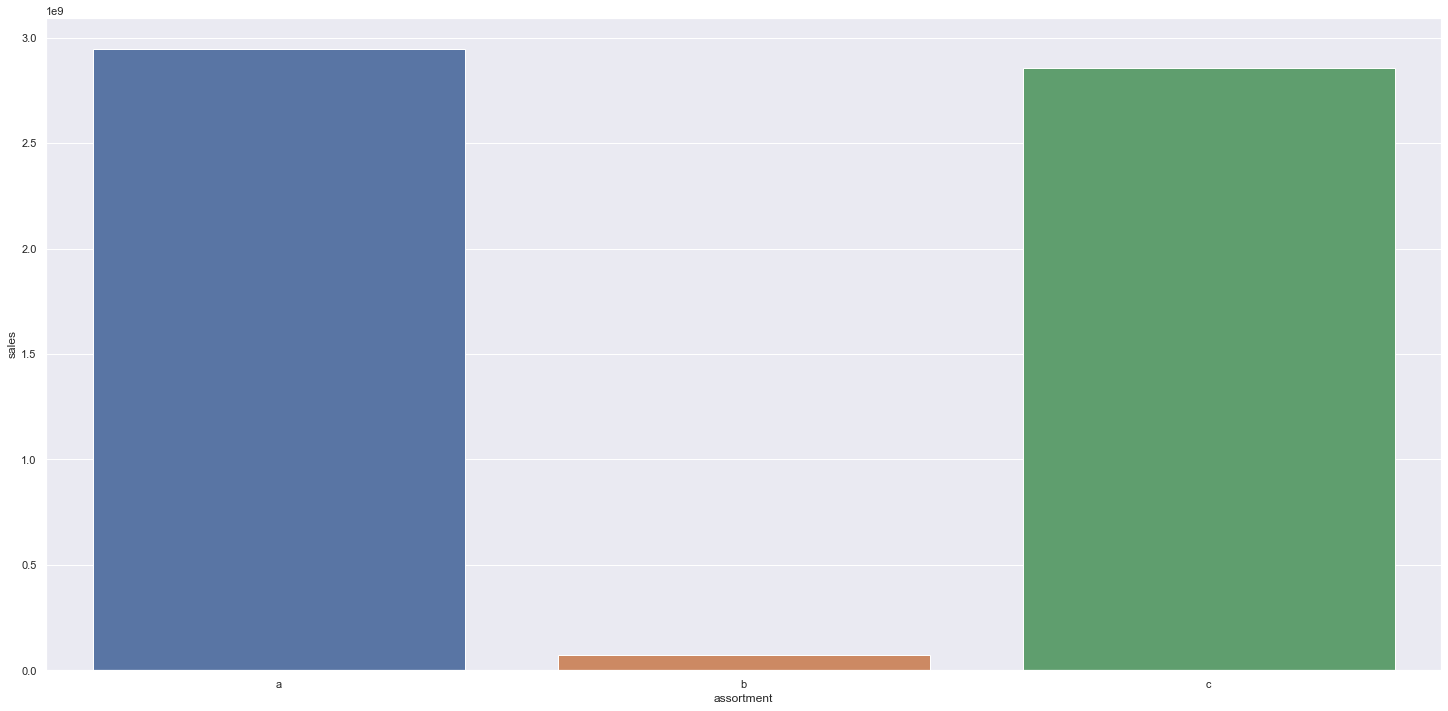

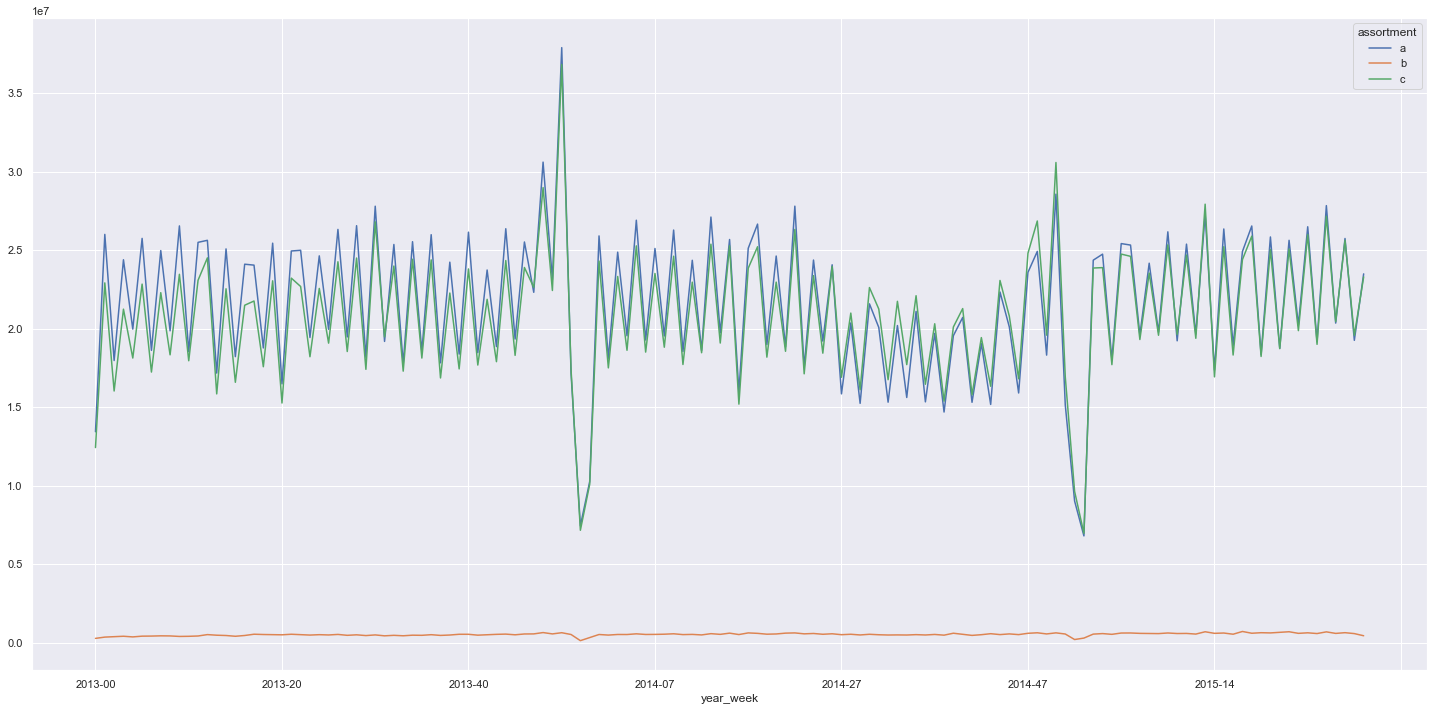

In [43]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()



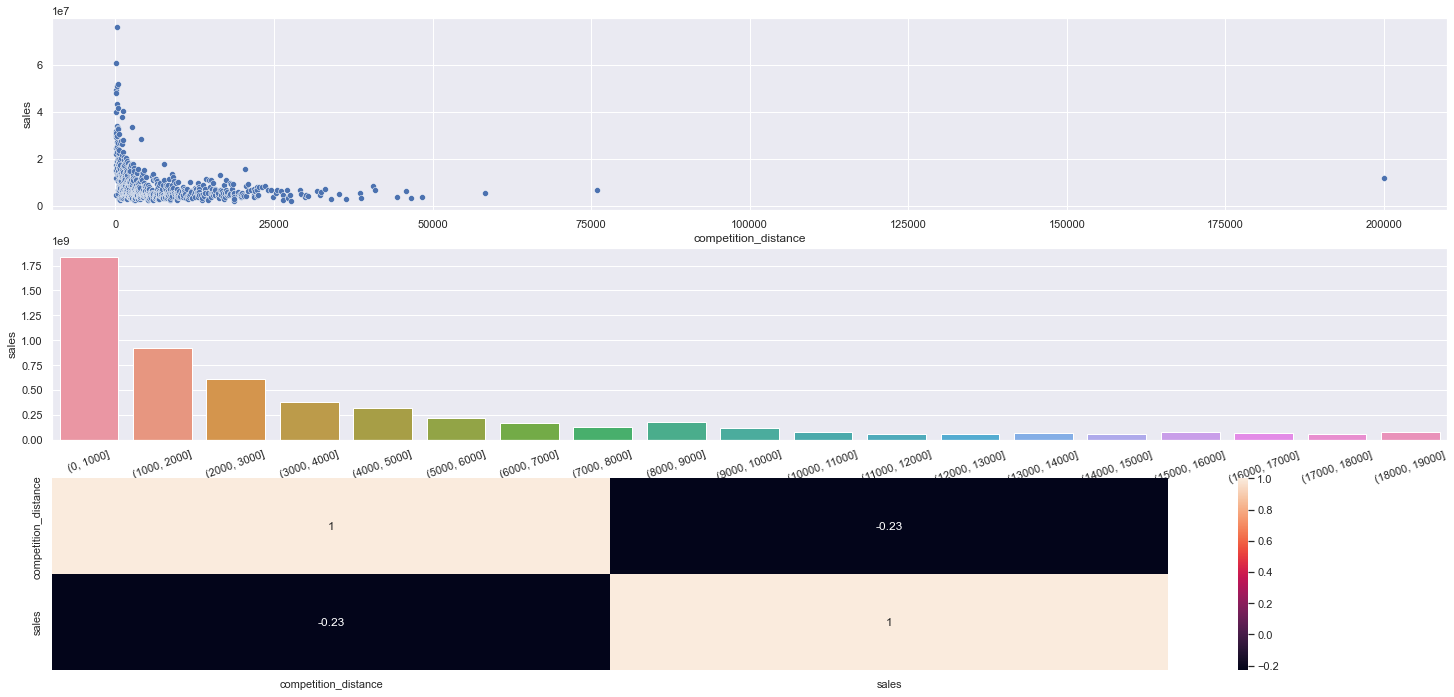

In [44]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(3, 1, 1)
sns.scatterplot(x= 'competition_distance', y= 'sales', data= aux1);

plt.subplot(3, 1, 2)
bins = list(np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.xticks(rotation = 20)
sns.barplot( x= 'competition_distance_binned', y= 'sales', data = aux2);

plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method= 'pearson'), annot= True);

In [45]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending = True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


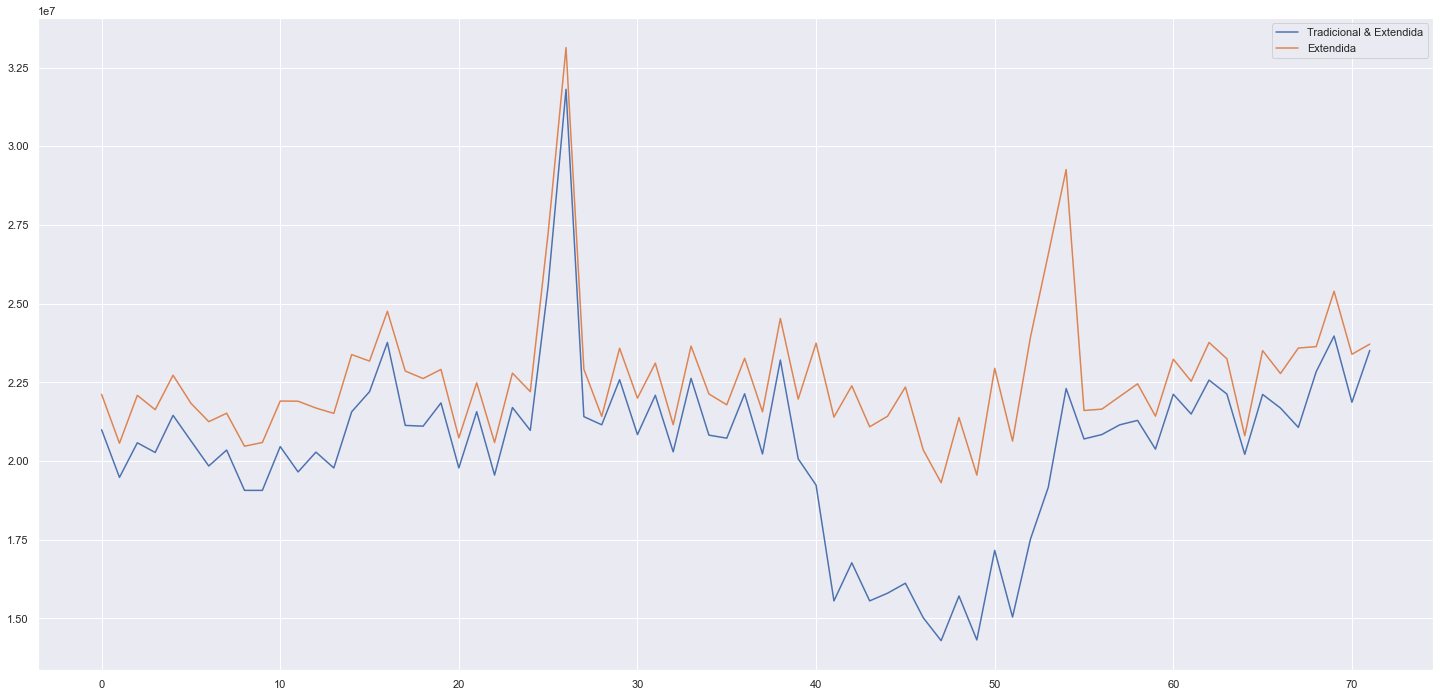

In [46]:
aux1 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax )

ax.legend( labels = ['Tradicional & Extendida', 'Extendida']);

### sales in Christmas hoday is more

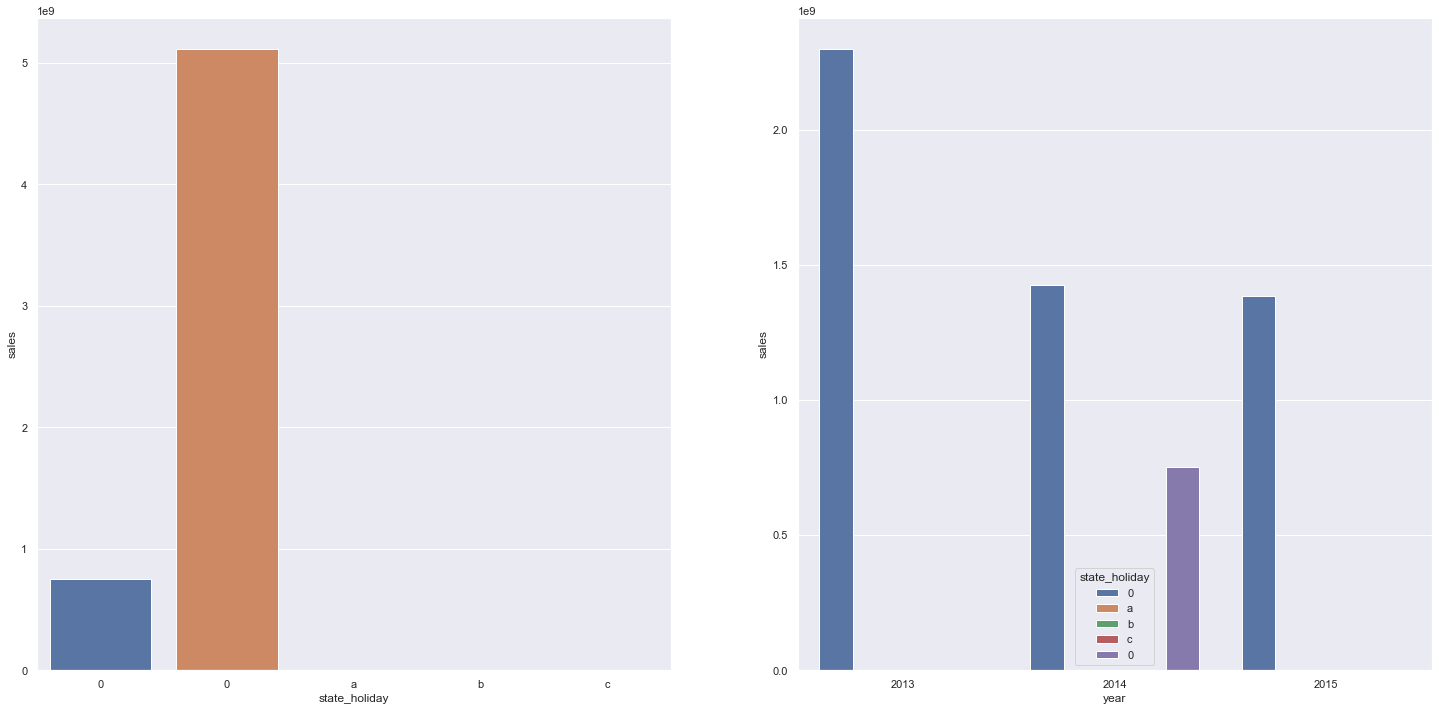

In [47]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux1, x= 'state_holiday', y= 'sales');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data = aux2, x = 'year', y= 'sales', hue= 'state_holiday');

### Stores should sell more over the years.

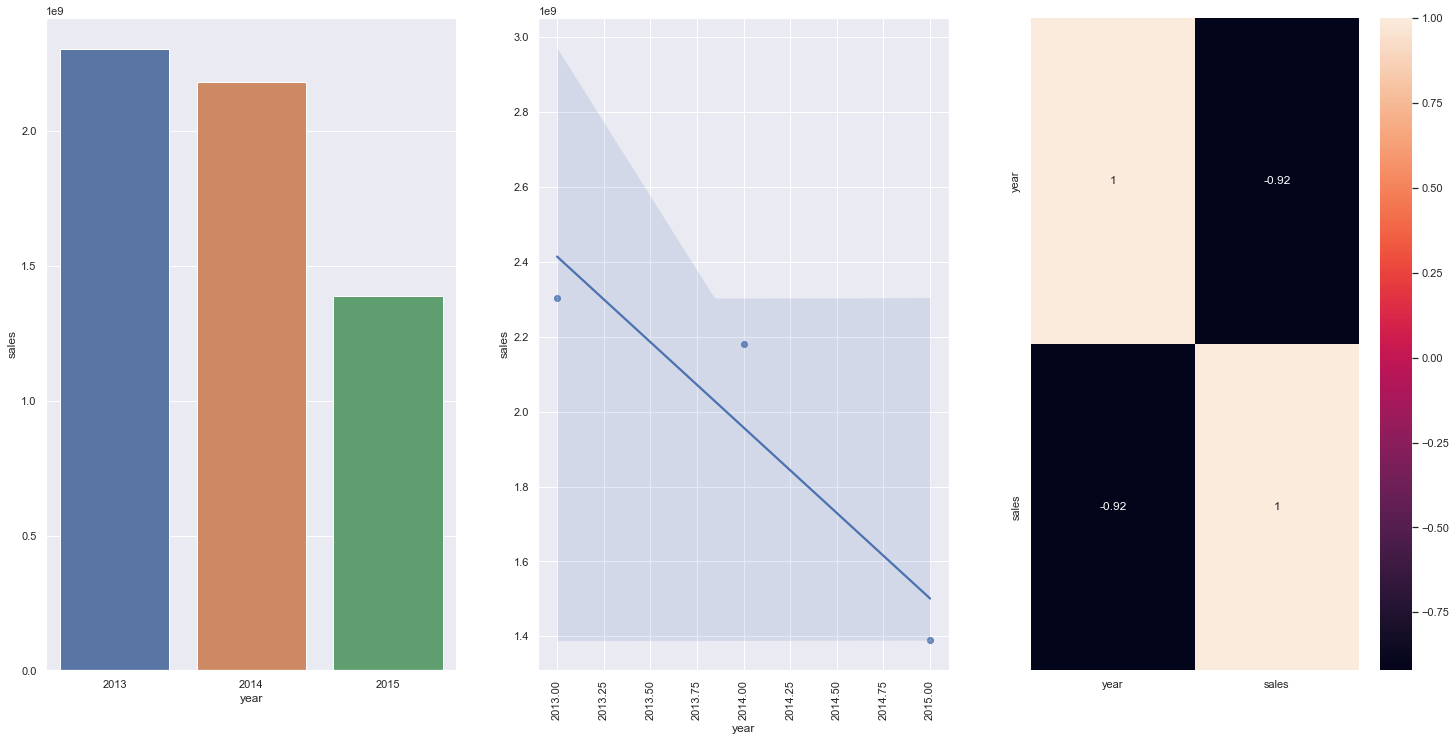

In [48]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'year', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'year', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

### Stores should sell more in the second half of the year.

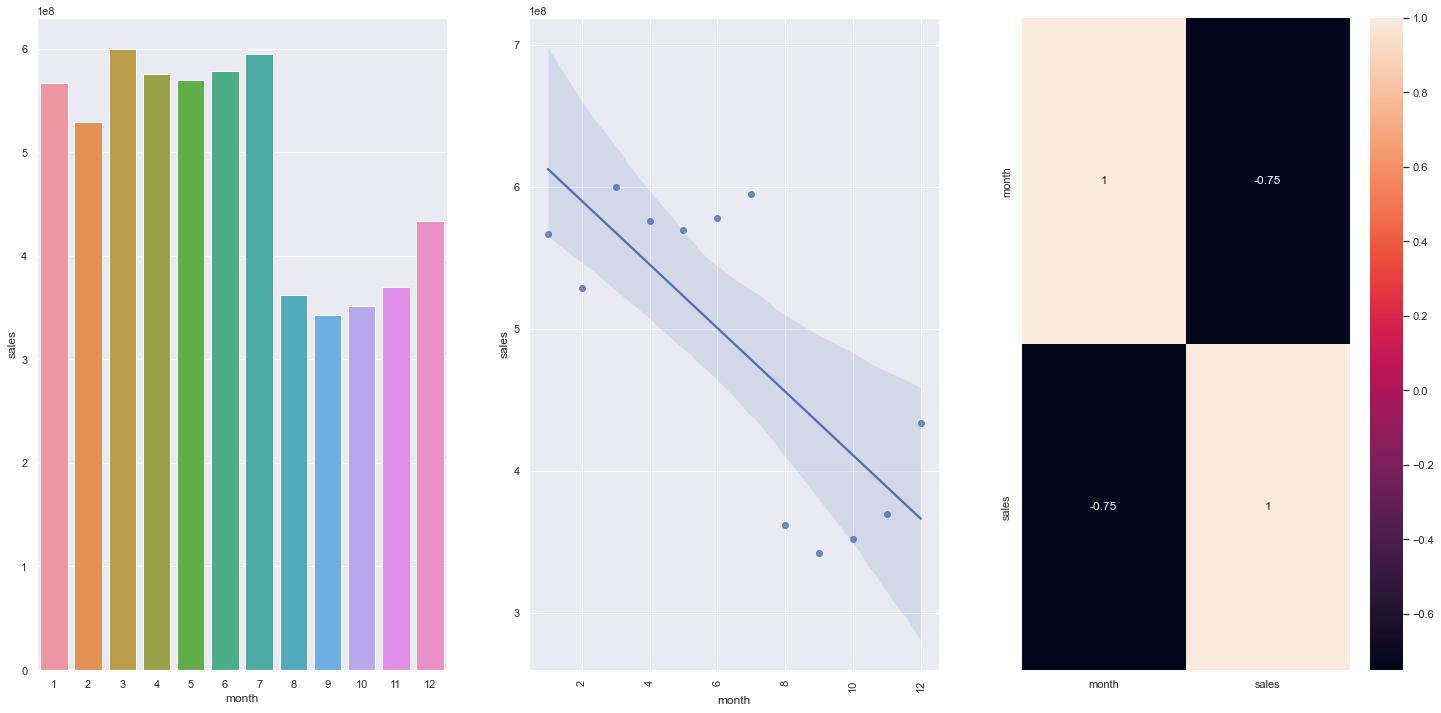

In [49]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'month', y= 'sales');   ###*tentar colocar legenda no gráfico em cima do semestre que vende menos*###

plt.subplot(132)
sns.regplot(data = aux, x= 'month', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

### Stores should sell less on weekends.

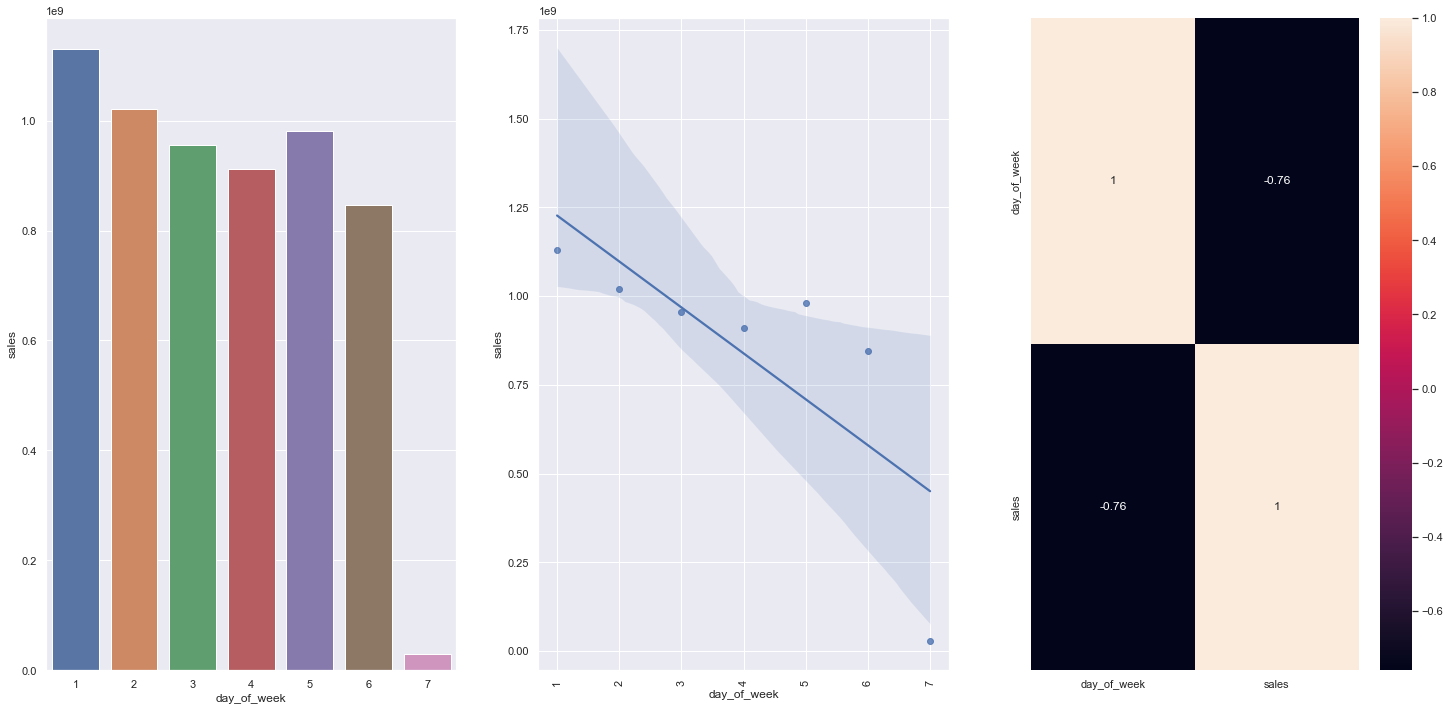

In [50]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(131)
sns.barplot(data = aux, x= 'day_of_week', y= 'sales');

plt.subplot(132)
sns.regplot(data = aux, x= 'day_of_week', y= 'sales');
plt.xticks(rotation = 90)

plt.subplot(133)
sns.heatmap(aux.corr(method= 'pearson'), annot = True);

### Stores should sell less during school holidays

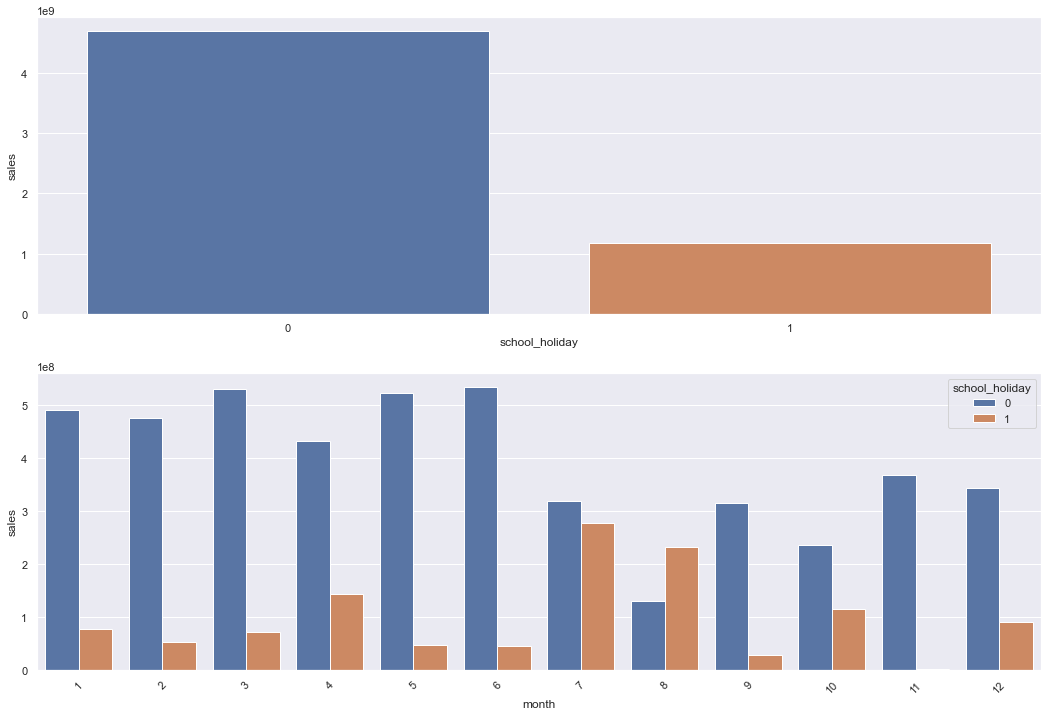

In [51]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index();

fig = plt.figure(figsize = (18,12))
plt.subplot(211)
sns.barplot(data = aux, x= 'school_holiday', y= 'sales');

aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index();

plt.subplot(212)
sns.barplot(data = aux2, x= 'month', y= 'sales', hue= 'school_holiday');
plt.xticks(rotation = 45);

### Summary 

In [52]:
summary = pd.DataFrame({'Hypothesis':['Stores with extended assortment type sell more.',
                                      'Stores with near competitors sell less.',
                                      'Stores with longer competitors should sell more.',
                                      'Stores with longer active promo should sell more.',
                                      'Stores with more promotion days should sell more.',
                                      'Stores with more consecutive promotions should sell more.',
                                      'Stores open during the Christmas holiday should sell more.',
                                      'Stores should sell more over the years.',
                                      'Stores should sell more in the second half of the year.',
                                      'Stores should sell more after the 10th of each month.',
                                      'Stores should sell less on weekends.',
                                      'Stores should sell less during school holidays.',
                                     ],
                        'True / False':['False', 'False', 'False', 'False', '-', 'False', 'False', 'False', 'False',
                                        'True','True', 'True'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', '-', 'Low', 'Medium', 'High', 'High', 
                                     'High', 'High', 'Low']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

,Hypothesis,True / False,Relevance
1,Stores with extended assortment type sell more.,False,Low
2,Stores with near competitors sell less.,False,Medium
3,Stores with longer competitors should sell more.,False,Medium
4,Stores with longer active promo should sell more.,False,Low
5,Stores with more promotion days should sell more.,-,-
6,Stores with more consecutive promotions should...,False,Low
7,Stores open during the Christmas holiday shoul...,False,Medium
8,Stores should sell more over the years.,False,High
9,Stores should sell more in the second half of ...,False,High
10,Stores should sell more after the 10th of each...,True,High


#### Multivariate Analysis

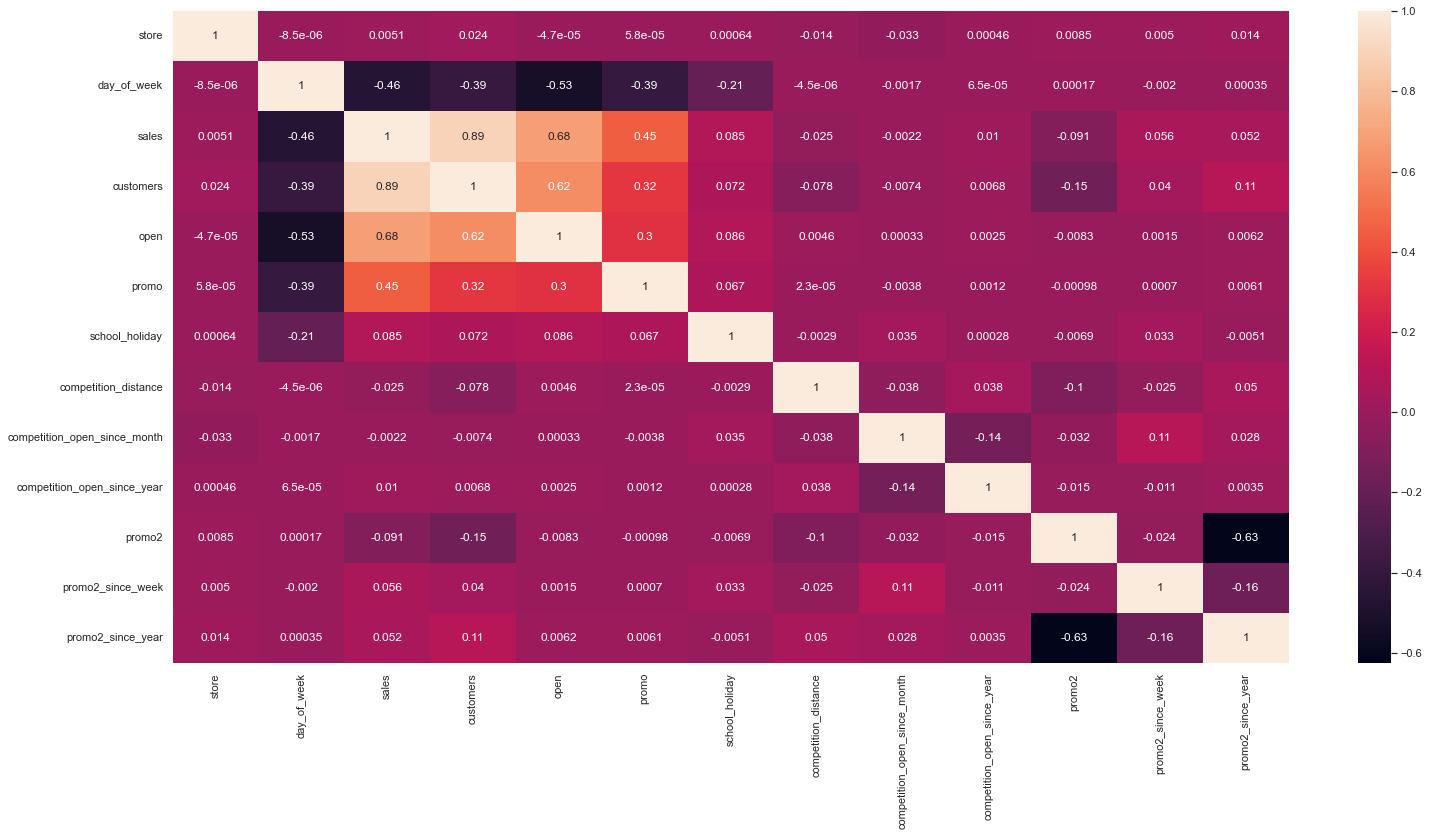

In [53]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

## Categorical Attributes

### DATA PREPARATION

In [54]:
df5 = df4.copy()

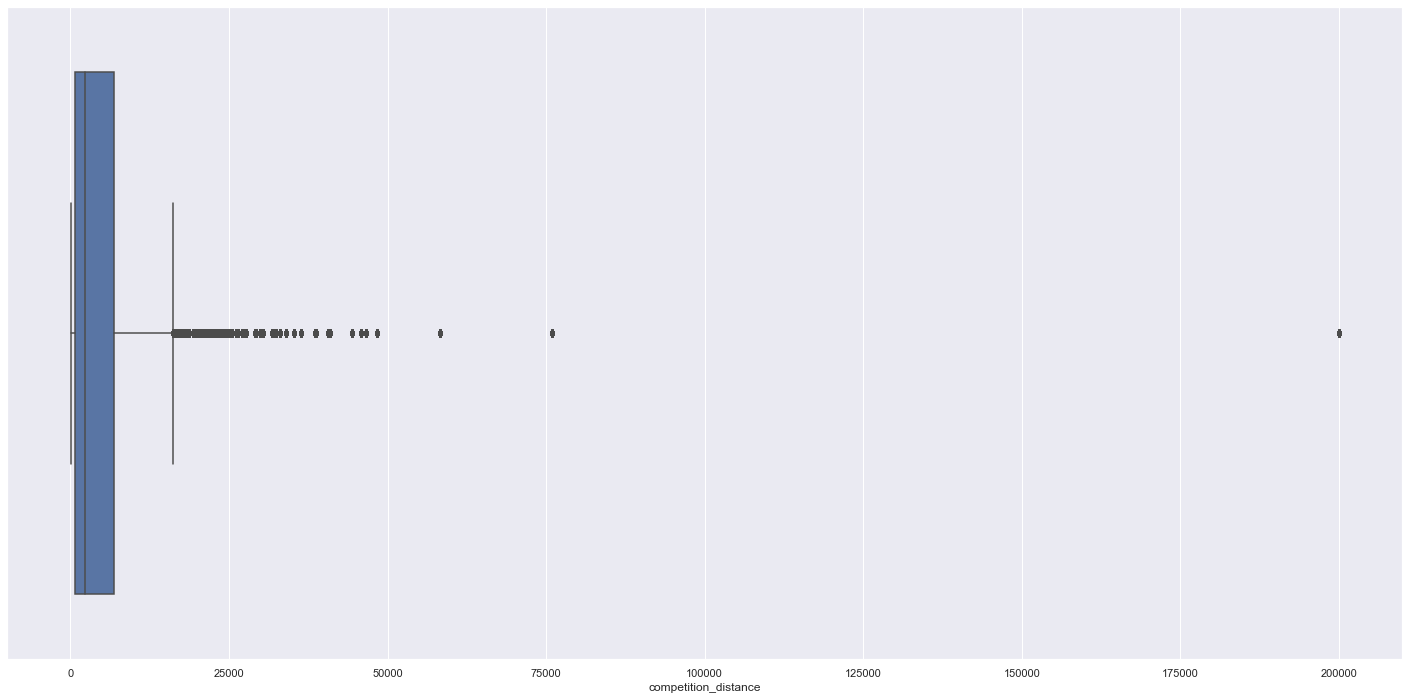

In [55]:
# boxplot to check outliers sensitivity
sns.boxplot(x = df5['competition_distance']);

In [56]:
df5.select_dtypes( include = 'object').head()

,state_holiday,store_type,assortment,year_week
0,0,c,a,2015-30
1,0,a,a,2015-30
2,0,a,a,2015-30
3,0,c,c,2015-30
4,0,a,a,2015-30


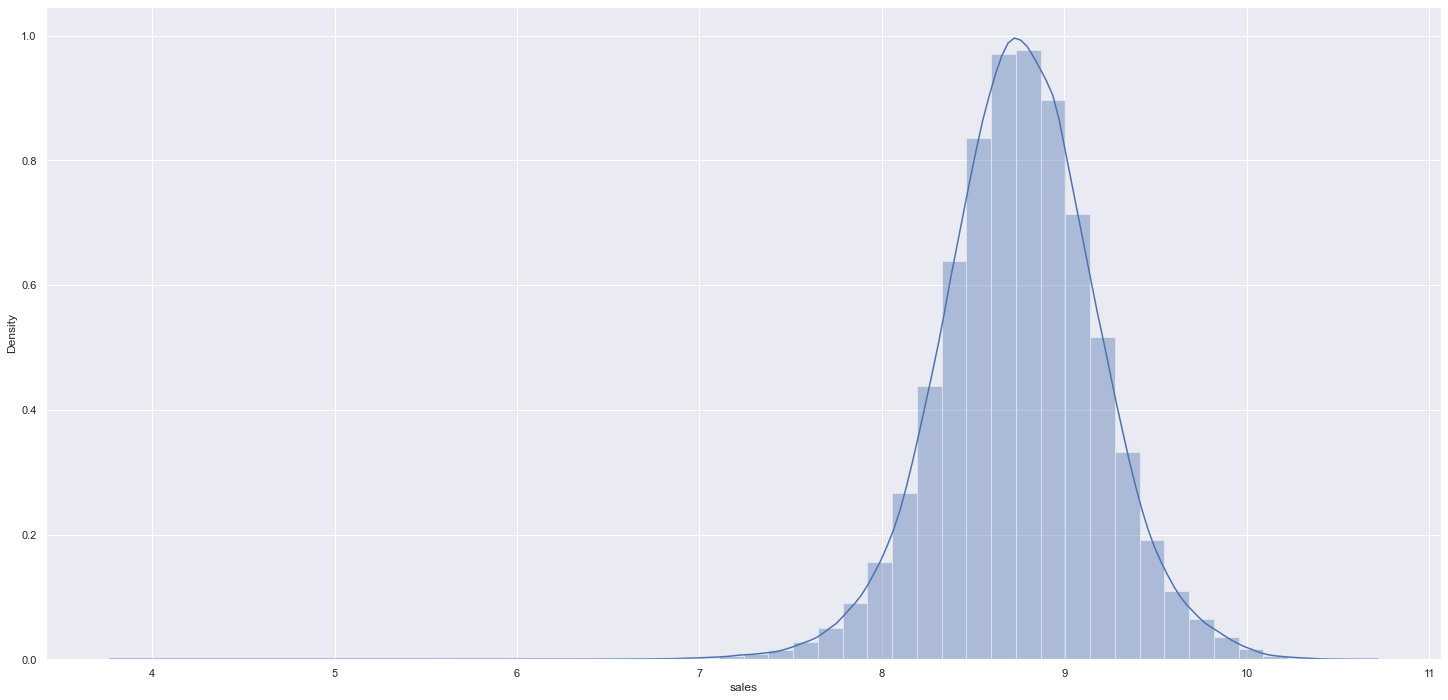

In [57]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales']);

In [64]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [67]:
#df5 = df5.astype({'store_type': 'int64'})
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
day_of_week_sin                        float64
day_of_week_c

In [68]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,2015,7,31,31,2015-30,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,2015,7,31,31,2015-30,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,2015,7,31,31,2015-30,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,2015,7,31,31,2015-30,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,2015,7,31,31,2015-30,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [69]:
df6 = df5.copy()

In [70]:
# Spliting dataframe into training and test. 
# Test will have the last 6 weeks of sales (i want to predict the next 6 weeks, and because of using time series i can make a randomic selection)
# starting at 2015-06-19 until the last day of sales

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [71]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### Feature selection 

In [72]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']

# columns to add
feat_to_add = ['date', 'sales']
# final features

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [73]:
pd.DataFrame(data = cols_selected_boruta, columns = ['feature_selected'])

,feature_selected
0,store
1,promo
2,store_type
3,assortment
4,competition_distance
5,competition_open_since_month
6,competition_open_since_year
7,promo2
8,promo2_since_week
9,promo2_since_year


### MACHINE LEARNING ALGORITHM MODELS

In [74]:
type(cols_selected_boruta_full)

list

In [87]:
import numpy as np 
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [97]:
df6['error'] = df6['sales'] - df6['predictions']
df6['error_rate'] = df6['predictions'] / df6['sales']
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df6, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df6, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df6 )
plt.axhline( 1, linestyle='--', color = 'red')

plt.subplot( 2, 2, 3 )
sns.distplot( df6['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df6['predictions'], df6['error'] )

KeyError: 'predictions'